In [2]:
import pandas as pd
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,MultiComparison)
import matplotlib.pyplot as plt
import numpy as np
from factor_analyzer import FactorAnalyzer

In [3]:
df = pd.read_csv('https://www.dropbox.com/s/2kgsd9x1fv1b7fl/rpe.csv?dl=1')
df.head()

,Date,PlayerID,Training,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,AcuteChronicRatio,ObjectiveRating,FocusRating,BestOutOfMyself
0,2018-07-21,13,Yes,Mobility/Recovery,5.0,0.0,0.0,446.0,323.1,303.25,1.07,NaN,NaN,Not at all
1,2018-07-21,13,Yes,Game,29.0,7.0,203.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all
2,2018-07-21,13,Yes,Game,27.0,9.0,243.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all
3,2018-07-20,11,Yes,Game,36.0,6.0,216.0,534.0,256.3,344.18,0.74,9.0,10.0,Absolutely
4,2018-07-20,11,Yes,Game,36.0,8.0,288.0,NaN,NaN,NaN,NaN,9.0,10.0,Absolutely


Since the ratio and load data are reported only once a day, we need to capture these NaN values from the same date data.

In [4]:
for i in range(len(df)):
     if i!= 0 and i < df.shape[0]:
            if df.loc[i,'Date'] == df.loc[i-1,'Date'] and df.loc[i,'PlayerID'] == df.loc[i-1,'PlayerID']:
                    df.loc[i,'DailyLoad'] = df.loc[i-1,'DailyLoad']
                    df.loc[i,'AcuteLoad'] = df.loc[i-1,'AcuteLoad']
                    df.loc[i,'ChronicLoad'] = df.loc[i-1,'ChronicLoad']
                    df.loc[i,'AcuteChronicRatio'] = df.loc[i-1,'AcuteChronicRatio']

In [5]:
df.head()

,Date,PlayerID,Training,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,AcuteChronicRatio,ObjectiveRating,FocusRating,BestOutOfMyself
0,2018-07-21,13,Yes,Mobility/Recovery,5.0,0.0,0.0,446.0,323.1,303.25,1.07,NaN,NaN,Not at all
1,2018-07-21,13,Yes,Game,29.0,7.0,203.0,446.0,323.1,303.25,1.07,NaN,NaN,Not at all
2,2018-07-21,13,Yes,Game,27.0,9.0,243.0,446.0,323.1,303.25,1.07,NaN,NaN,Not at all
3,2018-07-20,11,Yes,Game,36.0,6.0,216.0,534.0,256.3,344.18,0.74,9.0,10.0,Absolutely
4,2018-07-20,11,Yes,Game,36.0,8.0,288.0,534.0,256.3,344.18,0.74,9.0,10.0,Absolutely


In [38]:
print(list(df.columns))
df.shape

['Date', 'PlayerID', 'Training', 'SessionType', 'Duration', 'RPE', 'SessionLoad', 'DailyLoad', 'AcuteLoad', 'ChronicLoad', 'AcuteChronicRatio', 'ObjectiveRating', 'FocusRating', 'BestOutOfMyself']


(8860, 14)

Since there are too many missing values in ObjectiveRating and FocusRating, we will drop these two columns. Also, we decide to drop all the rows with missing values.

In [7]:
df = df.dropna(subset=['RPE'])
df = df.dropna(subset=['SessionType'])
df = df.dropna(subset=['Duration'])
df = df.dropna(subset=['SessionLoad'])
df = df[["Date","PlayerID","Training","SessionType","Duration","RPE",
        "SessionLoad","DailyLoad","AcuteLoad","ChronicLoad","AcuteChronicRatio"]]
df.shape

(7621, 11)

Also, we need to average the player's training load if they have multiple same sessions for one day.

In [9]:
df_rpe = df.groupby(['Date','PlayerID','SessionType'])['Duration',"RPE","SessionLoad","DailyLoad","AcuteLoad","ChronicLoad","AcuteChronicRatio"].mean()
df_rpe = df_rpe.reset_index()
# dimension is (7192, 10)
df_rpe.shape

(7192, 10)

Categorize the train load status into 3 groups. If the ratio is greater than 1.2, it is high training load. 
If it is smaller than 0.8, treat it as recovering, Everything else in between is regarded as normal.

In [21]:
conditions = [
    (df_rpe['AcuteChronicRatio'] <= 0.8),
    (df_rpe['AcuteChronicRatio'] > 0.8) & (df_rpe['AcuteChronicRatio'] < 1.2),
    (df_rpe['AcuteChronicRatio'] >=1.2)]
choices = ['recovering', 'normal', 'high']
df_rpe["Load_Status"] = np.select(conditions,choices)

In [11]:
df_rpe.head()

,Date,PlayerID,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,AcuteChronicRatio,Load Status
0,2017-08-01,1,Speed,60.0,3.0,180.0,540.0,77.1,19.29,4.00,high
1,2017-08-01,1,Strength,90.0,4.0,360.0,540.0,77.1,19.29,4.00,high
2,2017-08-01,3,Speed,45.0,5.0,225.0,675.0,96.4,24.11,4.00,high
3,2017-08-01,3,Strength,90.0,5.0,450.0,675.0,96.4,24.11,4.00,high
4,2017-08-01,5,Speed,30.0,3.0,90.0,330.0,47.1,11.79,3.99,high


## Some Visualizations

In [13]:
df.groupby(df_rpe["SessionType"])["SessionType"].count()


SessionType
Combat                171
Conditioning          783
Game                  185
Mobility/Recovery     790
Skills               1522
Speed                1075
Strength             1642
Name: SessionType, dtype: int64

<Figure size 7200x3600 with 0 Axes>

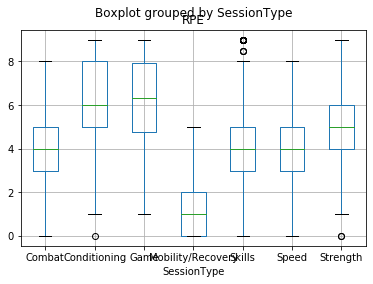

<Figure size 7200x3600 with 0 Axes>

In [14]:
df_rpe.boxplot(column = 'RPE',by = 'SessionType')
plt.figure(figsize=(100,50))

In order to confirm what variables will affect RPE, we conduct Tukey Test on multiple variables. The first one is as below, which is the impact of SessionType on RPE. The null hypothesis is the mean of each pair of groups are equal. From here, we can see most of null hypothesis are rejected. We can conclude that SessionType will have impact on RPE.

In [23]:
pairwise_tukeyhsd(df_rpe["RPE"],df_rpe["SessionType"]).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Combat,Conditioning,2.0649,0.001,1.7055,2.4243,True
Combat,Game,2.0616,0.001,1.6236,2.4997,True
Combat,Mobility/Recovery,-3.1434,0.001,-3.5006,-2.7862,True
Combat,Skills,-0.1644,0.7673,-0.5069,0.1782,False
Combat,Speed,-0.1779,0.7177,-0.5278,0.172,False
Combat,Strength,0.8625,0.001,0.5209,1.2041,True
Conditioning,Game,-0.0033,0.9,-0.3336,0.3271,False
Conditioning,Mobility/Recovery,-5.2083,0.001,-5.42,-4.9965,True
Conditioning,Skills,-2.2293,0.001,-2.4153,-2.0433,True
Conditioning,Speed,-2.2428,0.001,-2.4421,-2.0436,True


In [24]:
pairwise_tukeyhsd(df_rpe["RPE"],df_rpe["Load_Status"]).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
high,normal,-0.3439,0.001,-0.4852,-0.2026,True
high,recovering,-0.6984,0.001,-0.8415,-0.5552,True
normal,recovering,-0.3545,0.001,-0.4979,-0.211,True


Since most of groups have different mean for RPE, we can include that Load Status is highly correlated to RPE

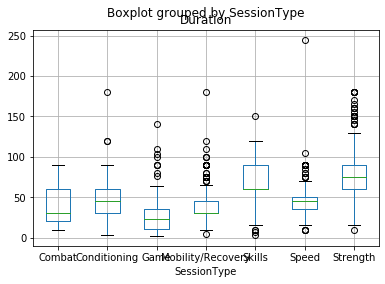

In [25]:
df.boxplot(column = 'Duration',by = 'SessionType')

In [26]:
pairwise_tukeyhsd(df_rpe["Duration"],df_rpe["SessionType"]).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Combat,Conditioning,8.3906,0.001,3.4943,13.287,True
Combat,Game,-13.6171,0.001,-19.5848,-7.6494,True
Combat,Mobility/Recovery,-2.2146,0.8103,-7.0811,2.6518,False
Combat,Skills,27.3041,0.001,22.6372,31.9711,True
Combat,Speed,4.6144,0.0654,-0.1529,9.3816,False
Combat,Strength,37.7416,0.001,33.0872,42.396,True
Conditioning,Game,-22.0077,0.001,-26.5084,-17.5071,True
Conditioning,Mobility/Recovery,-10.6053,0.001,-13.4905,-7.72,True
Conditioning,Skills,18.9135,0.001,16.3792,21.4478,True
Conditioning,Speed,-3.7763,0.001,-6.4909,-1.0617,True


In [29]:
df_rpe.groupby(df_rpe["Load_Status"])["Load_Status"].count()


Load_Status
high          2451
normal        2430
recovering    2311
Name: Load_Status, dtype: int64

### Factor Analysis

In [31]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(df_rpe)
chi_square_value, p_value

(31406.403020206555, 0.0)

In this Bartlett ’s test, the p-value is nearly 0. The test was statistically significant, indicating that the observed correlation matrix is not an identity matrix.

In [33]:
df_part = df_rpe[["Duration","RPE","SessionLoad","DailyLoad",
                  "AcuteLoad","ChronicLoad","AcuteChronicRatio"]]

In [34]:
#Factor Analysis 

from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer()
fa.analyze(df_part, 7, rotation=None)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

,Original_Eigenvalues
0,2.972944
1,1.550703
2,1.181557
3,0.687368
4,0.421093
5,0.115795
6,0.070539


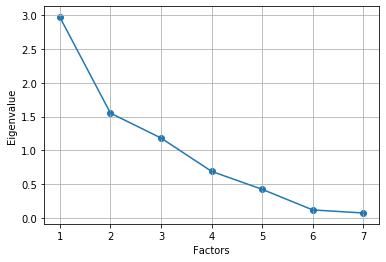

In [35]:
plt.scatter(range(1,7+1),ev)
plt.plot(range(1,7+1),ev)

plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

There are 3 eigenvalues greater than 1, which means 3 factors should be considered.

In [36]:
fa = FactorAnalyzer()
fa.analyze(df_part, 3, rotation="varimax")
fa.loadings


,Factor1,Factor2,Factor3
Duration,0.704403,0.041360,0.074935
RPE,0.606111,0.009468,0.152493
SessionLoad,1.025965,0.015627,0.133822
DailyLoad,0.461509,0.117824,0.504339
AcuteLoad,0.166842,0.112676,0.967606
ChronicLoad,0.058258,-0.582994,0.637376
AcuteChronicRatio,0.087478,0.983429,0.143356


In [38]:
df_per = pd.read_csv('https://raw.githubusercontent.com/weilixiang/sta2453_project1/master/Clean%20Data/' +
                          'PerformanceMeasure.csv')

In [40]:
from datetime import datetime  
from datetime import timedelta

fmt = '%Y-%m-%d'
df_per["train_date"]  = (pd.to_datetime(df_per["Date"], format=fmt) - pd.Timedelta('1 days')).dt.strftime(date_format=fmt)
df_per.head()

,GameID,Date,PlayerID,AccelImpulse,AccelLoad,Speed,PerformanceScore,Outcome,PointsDiff,train_date
0,1,2017-11-30,2,0.524367,0.264378,0.754193,51.431257,W,19,2017-11-29
1,2,2017-11-30,2,0.524367,0.264378,0.754193,51.431257,W,31,2017-11-29
2,3,2017-11-30,2,0.524367,0.264378,0.754193,51.431257,W,17,2017-11-29
3,1,2017-11-30,3,0.452520,0.333518,0.753256,51.309794,W,19,2017-11-29
4,2,2017-11-30,3,0.452520,0.333518,0.753256,51.309794,W,31,2017-11-29


In [42]:
new_df = pd.DataFrame(np.dot(df_part,fa.loadings))
new_data = pd.DataFrame({"Date":df_rpe["Date"].tolist(),"PlayerID":df_rpe["PlayerID"].tolist(),
        "FactorSessionLoad":new_df[0].tolist(), "FactorRatio":new_df[1].tolist(),
            "FactorAcuteLoad":new_df[2].to_list()})
df_factor = pd.merge(new_data, df_per,  how='left',left_on=['Date','PlayerID'],right_on=["train_date",'PlayerID'])
df_factor  = df_factor.dropna()
df_factor.head()


,Date_x,PlayerID,FactorSessionLoad,FactorRatio,FactorAcuteLoad,GameID,Date_y,AccelImpulse,AccelLoad,Speed,PerformanceScore,Outcome,PointsDiff,train_date
2690,2017-11-29,2,652.915819,-140.374072,645.674315,1.0,2017-11-30,0.524367,0.264378,0.754193,51.431257,W,19.0,2017-11-29
2691,2017-11-29,2,652.915819,-140.374072,645.674315,2.0,2017-11-30,0.524367,0.264378,0.754193,51.431257,W,31.0,2017-11-29
2692,2017-11-29,2,652.915819,-140.374072,645.674315,3.0,2017-11-30,0.524367,0.264378,0.754193,51.431257,W,17.0,2017-11-29
2693,2017-11-29,3,648.036229,-188.874382,758.601087,1.0,2017-11-30,0.452520,0.333518,0.753256,51.309794,W,19.0,2017-11-29
2694,2017-11-29,3,648.036229,-188.874382,758.601087,2.0,2017-11-30,0.452520,0.333518,0.753256,51.309794,W,31.0,2017-11-29


### How is new factor?
Plot new factors relative to Performance to see if there is any significant pattern or trend

Text(0, 0.5, 'Acceleration Impulse')

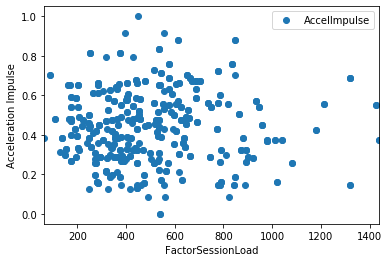

In [44]:
df_factor.plot(x="FactorSessionLoad",y="AccelImpulse",style="o")
plt.ylabel("Acceleration Impulse")

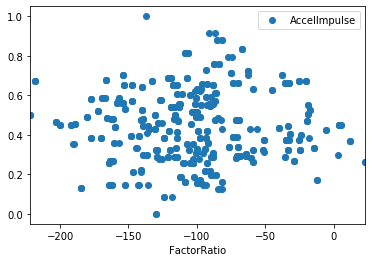

In [45]:
df_factor.plot(x="FactorRatio",y="AccelImpulse",style="o")

We cannot see any clear trend or pattern here, then we decide to take some transformation of our response.
The first we can think of is log transformation

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


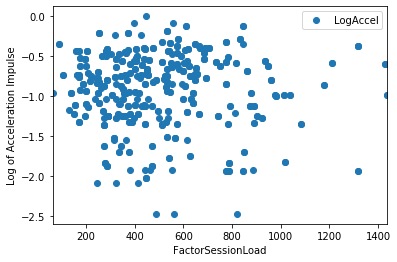

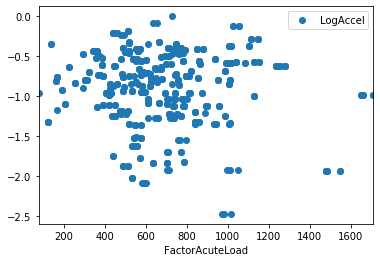

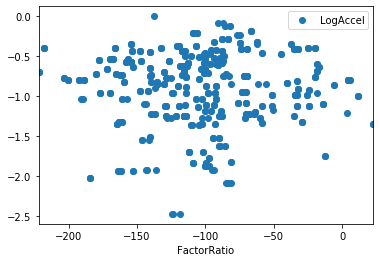

In [48]:
df_factor["LogAccel"] = np.log(df_factor["AccelImpulse"])
df_factor.plot(x="FactorSessionLoad",y="LogAccel",style="o")
plt.ylabel("Log of Acceleration Impulse")
df_factor.plot(x="FactorAcuteLoad",y="LogAccel",style="o")
df_factor.plot(x="FactorRatio",y="LogAccel",style="o")

To be honest, data points do not spread out as well. We start to think our measurement for performance is not good if we only use Acceleration Impulse. This is the reason why we have PerformanceScore as a new measurement of performance, which take Acceleration Impulse, Acceleration Load, and Max speed into consideration.